In [1]:
from scipy.stats import mode
from sklearn.ensemble import RandomForestClassifier
from statsmodels.discrete.discrete_model import Logit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')

In [3]:
test = pd.read_csv('test.csv')

In [4]:
# VARIABLE DESCRIPTIONS:
# survival        Survival
#                 (0 = No; 1 = Yes)
# pclass          Passenger Class
#                 (1 = 1st; 2 = 2nd; 3 = 3rd)
# name            Name
# sex             Sex
# age             Age
# sibsp           Number of Siblings/Spouses Aboard
# parch           Number of Parents/Children Aboard
# ticket          Ticket Number
# fare            Passenger Fare
# cabin           Cabin
# embarked        Port of Embarkation
#                 (C = Cherbourg; Q = Queenstown; S = Southampton)

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
# age missing data, cabin data very sparse
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [7]:
# embarked missing a couple data points
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [8]:
train.describe()

/Users/carmenlai/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,NaN,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,NaN,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,NaN,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
# numeric features
numeric = ['Survived', 'Age', 'Pclass', 'SibSp', 'Parch', 'Fare']

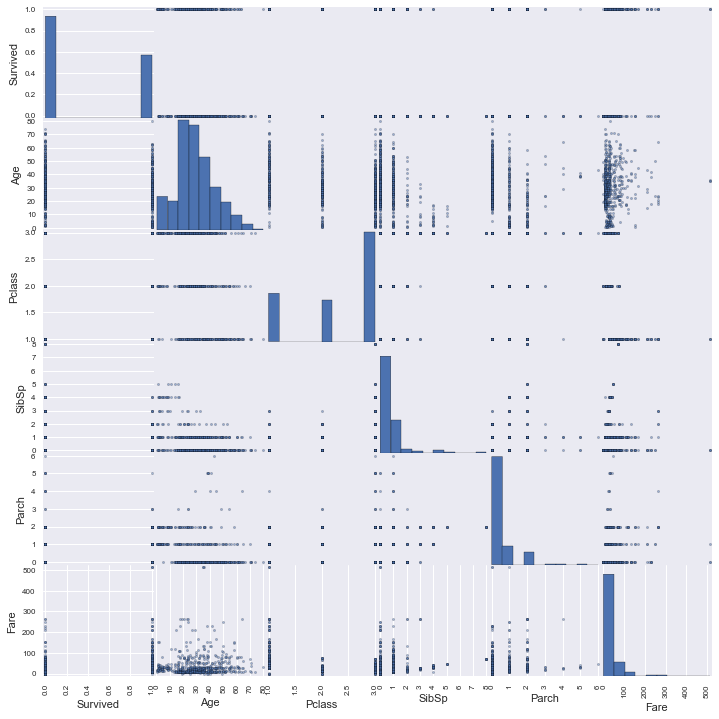

In [10]:
pd.scatter_matrix(train[numeric], figsize=(12, 12));

### Greater proportion of 1st class survive

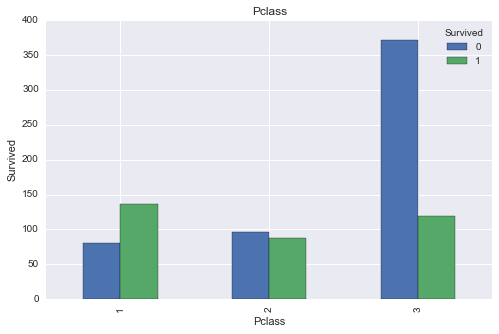

In [11]:
agg = train.groupby(by=['Pclass', 'Survived']).apply(len)
agg.unstack().plot(kind='bar', figsize=(8,5))
plt.title('Pclass')
plt.ylabel('Survived');

### Greater proportion of women survive

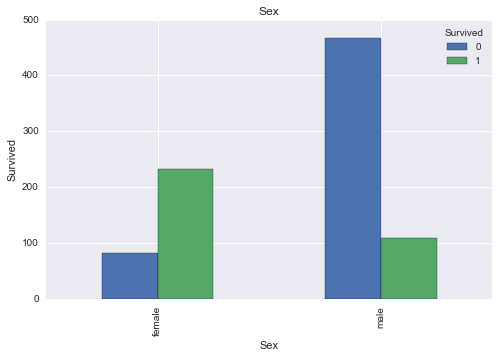

In [ ]:
agg = train.groupby(by=['Sex', 'Survived']).apply(len)
agg.unstack().plot(kind='bar', figsize=(8,5))
plt.title('Sex')
plt.ylabel('Survived');

### Not a huge difference in age

In [ ]:
plt.figure(figsize=(8,8))
sns.boxplot(train['Age'], groupby=train['Survived']);

/Users/carmenlai/anaconda2/lib/python2.7/site-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


In [ ]:
sns.kdeplot(train["Age"], shade=True)
sns.rugplot(train["Age"])
plt.show()

### Cleaning the data

In [ ]:
def cabin_prefix(X):
    X['Cabin'] = X['Cabin'].fillna('Unknown').str[0]


def fill_age_with_median(X):
    # In case there may be something meaningful about missing age
    X['AgeMissing'] = X['Age'].isnull().astype(int)
    X['Age'] = X['Age'].fillna(X['Age'].median())


def fill_embarked_with_mode(X):
    X['Embarked'] = X['Embarked'].fillna(X['Embarked'].mode()[0])


def fill_fare_with_mean(X):
    X['Fare'] = X['Fare'].fillna(X['Fare'].mean())


def remove_id_name_ticket(X, remove_id=True):
    if remove_id:
        del X['PassengerId']
    del X['Name']
    del X['Ticket']


def family_size_vars(X):
    X['TotalFamily'] = X['SibSp'] + X['Parch']
    X['SelfOnly'] = X['TotalFamily'].map(lambda x: 1 if x == 0 else 0)


def categorical_dummies(X, *cols):
    for col in cols:
        dummies = pd.get_dummies(
            X[col], prefix=col, drop_first=True)
        X = pd.concat([X, dummies], axis=1)
        del X[col]
    return X

X = train.copy()
y = X.pop('Survived')

cabin_prefix(X)
fill_age_with_median(X)
fill_embarked_with_mode(X)
fill_fare_with_mean(X)
remove_id_name_ticket(X)
family_size_vars(X)
X = categorical_dummies(X, 'Pclass', 'Sex', 'Cabin', 'Embarked')

In [ ]:
X.head()

### Feature importance

In [ ]:
def feature_importances(clf, X, y):
    clf.fit(X, y)

    features = pd.DataFrame()
    features['feature'] = X.columns
    features['importance'] = clf.feature_importances_

    return features.sort_values(['importance'], ascending=False).reset_index(drop=True)


def plot_feature_importances(importances):
    importances_plt = importances.sort_values(
        ['importance'], ascending=True).reset_index(drop=True)
    ind = importances_plt.index
    plt.figure(figsize=(12,8))
    plt.barh(ind, importances_plt['importance'], height=.3, align='center')
    plt.title('Feature Importances')
    plt.ylim(ind.min() + .5, ind.max() + .5)
    plt.yticks(ind, importances_plt['feature'])

clf = RandomForestClassifier(n_estimators=1000, oob_score=True)
importances = feature_importances(clf, X, y)
select = list(importances['feature'][:15])
plot_feature_importances(importances)
plt.show()

### Single passengers less likely to survive

In [ ]:
agg = train.groupby(by=['SibSp', 'Survived']).apply(len)
agg.unstack().plot(kind='bar', figsize=(8,5))
plt.title('Survival by Number of Siblings/Spouse')
plt.ylabel('Survived');
# only childs were less likely to survive :(

In [ ]:
agg = train.groupby(by=['Parch', 'Survived']).apply(len)
agg.unstack().plot(kind='bar', figsize=(8,5))
plt.title('Survival by Number of Parents/Children')
plt.ylabel('Survived');

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression

In [ ]:
fit = smf.logit('Survived ~ 1 + Sex + Age + Fare', data=train)
fit = fit.fit()
fit.summary()

In [ ]:
fit1 = smf.logit('Survived ~ 1 + Pclass + Sex + Age + SibSp', data=train)
fit1 = fit1.fit()
fit1.summary()